In [1]:
using Pkg
Pkg.activate("..")
Pkg.precompile()

  Activating project at `~/Projects/bind_RBM`


In [2]:
using Random: bitrand
using RestrictedBoltzmannMachines: mean_from_inputs
using RestrictedBoltzmannMachines: sample_from_inputs, inputs_h_from_v
using RestrictedBoltzmannMachines: sample_h_from_v
using DelimitedFiles, LinearAlgebra, Statistics, Random
using RestrictedBoltzmannMachines: RBM, Potts, Binary, ReLU, nsReLU, log_pseudolikelihood, initialize!, pcd!,
    sample_from_inputs, sample_v_from_v, free_energy, onehot_encode, sample_h_from_v
using Statistics: mean, cov, std, var, cor
using LinearAlgebra: norm
const ALPHABET = "ACDEFGHIKLMNPQRSTVWY-"
alphabet_dict = Dict(c => i for (i, c) in enumerate(ALPHABET))
using JLD2
using MultivariateStats
using CairoMakie
using MLJ, MLJLinearModels
using DataFrames
using Logging
using Makie
using Serialization
using MultivariateStats
using XLSX
using Clustering

using bind_RBM: create_binding_dictionary_Gogl, one_hot_encode, create_binding_dictionary, compute_covariance_matrix, onehot_encode_2d, plot_label_matrix
alphabet = collect("ACDEFGHIKLMNPQRSTVWY-")


21-element Vector{Char}:
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'C': ASCII/Unicode U+0043 (category Lu: Letter, uppercase)
 'D': ASCII/Unicode U+0044 (category Lu: Letter, uppercase)
 'E': ASCII/Unicode U+0045 (category Lu: Letter, uppercase)
 'F': ASCII/Unicode U+0046 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'H': ASCII/Unicode U+0048 (category Lu: Letter, uppercase)
 'I': ASCII/Unicode U+0049 (category Lu: Letter, uppercase)
 'K': ASCII/Unicode U+004B (category Lu: Letter, uppercase)
 'L': ASCII/Unicode U+004C (category Lu: Letter, uppercase)
 'M': ASCII/Unicode U+004D (category Lu: Letter, uppercase)
 'N': ASCII/Unicode U+004E (category Lu: Letter, uppercase)
 'P': ASCII/Unicode U+0050 (category Lu: Letter, uppercase)
 'Q': ASCII/Unicode U+0051 (category Lu: Letter, uppercase)
 'R': ASCII/Unicode U+0052 (category Lu: Letter, uppercase)
 'S': ASCII/Unicode U+0053 (category Lu: Letter, uppercase)
 'T': ASCII/Uni

In [3]:
data_Gogl = create_binding_dictionary_Gogl("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/PDZ_2022.xlsx", "/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/PDZ_2022_final.xlsx", 4)
data_Stiffler = create_binding_dictionary("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/output.txt")
seqs_Gogl = collect(keys(data_Gogl))
onehot_seq = one_hot_encode(seqs_Gogl, alphabet, alphabet_dict)

seqs_Stiffler = collect(keys(data_Stiffler))
onehot_seq_Stif = one_hot_encode(seqs_Stiffler, alphabet, alphabet_dict)



Skipped rows: 2037


21×81×84 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [8]:
function unique_elements_from_dict(d::Dict)
    uniq = Set{String}()
    for v in values(d)
        union!(uniq, v.elements)
    end
    return uniq
end

uniq_Gogl     = unique_elements_from_dict(data_Gogl)
uniq_Stiffler = unique_elements_from_dict(data_Stiffler)

common = intersect(uniq_Gogl, uniq_Stiffler)
n_common = length(common)

println("Unique elements in common: ", n_common)

function filter_dict_by_elements(d::Dict, common_elements::Set{String})
    out = Dict{eltype(keys(d)), eltype(values(d))}()

    for (k, v) in d
        filtered = [e for e in v.elements if e in common_elements]

        if !isempty(filtered)
            # reconstruct named tuple, replacing only `elements`
            out[k] = merge(v, (elements = filtered,))
        end
    end

    return out
end


filtered_Gogl     = filter_dict_by_elements(data_Gogl, common)
filtered_Stiffler = filter_dict_by_elements(data_Stiffler, common)

union_dict = merge(filtered_Gogl, filtered_Stiffler)
union_tot = merge(data_Gogl, data_Stiffler)

n_ones = sum(
    count(==(1), v.labels)
    for v in values(union_dict)   # or whatever your dict is called
)

n_total = sum(length(v.labels) for v in values(union_dict))

println("Fraction of 1s: ", n_ones / n_total)

Unique elements in common: 53
Fraction of 1s: 0.10672382147254943


In [5]:
cov_matrix_Gogl = compute_covariance_matrix(data_Gogl, alphabet, alphabet_dict)
cov_matrix_Stiffler = compute_covariance_matrix(data_Stiffler, alphabet, alphabet_dict)
cov_matrix_tot = compute_covariance_matrix(union_dict, alphabet, alphabet_dict)

1701×210 Matrix{Float32}:
  0.0           0.0          …  0.0   0.0          0.0  0.0  0.0
  0.0           0.0             0.0   0.0          0.0  0.0  0.0
  0.0           0.0             0.0   0.0          0.0  0.0  0.0
 -5.34266f-6    0.00020102      0.0  -0.0001476    0.0  0.0  0.0
  0.0           0.0             0.0   0.0          0.0  0.0  0.0
  0.0           0.0          …  0.0   0.0          0.0  0.0  0.0
  0.0           0.0             0.0   0.0          0.0  0.0  0.0
  0.0           0.0             0.0   0.0          0.0  0.0  0.0
  0.0           0.0             0.0   0.0          0.0  0.0  0.0
  0.0           0.0             0.0   0.0          0.0  0.0  0.0
  0.0           0.0          …  0.0   0.0          0.0  0.0  0.0
  0.0           0.0             0.0   0.0          0.0  0.0  0.0
  0.0           0.0             0.0   0.0          0.0  0.0  0.0
  ⋮                          ⋱  ⋮                            
 -3.4375f-5    -0.000278011     0.0   0.000139818  0.0  0.0  0.0
  

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


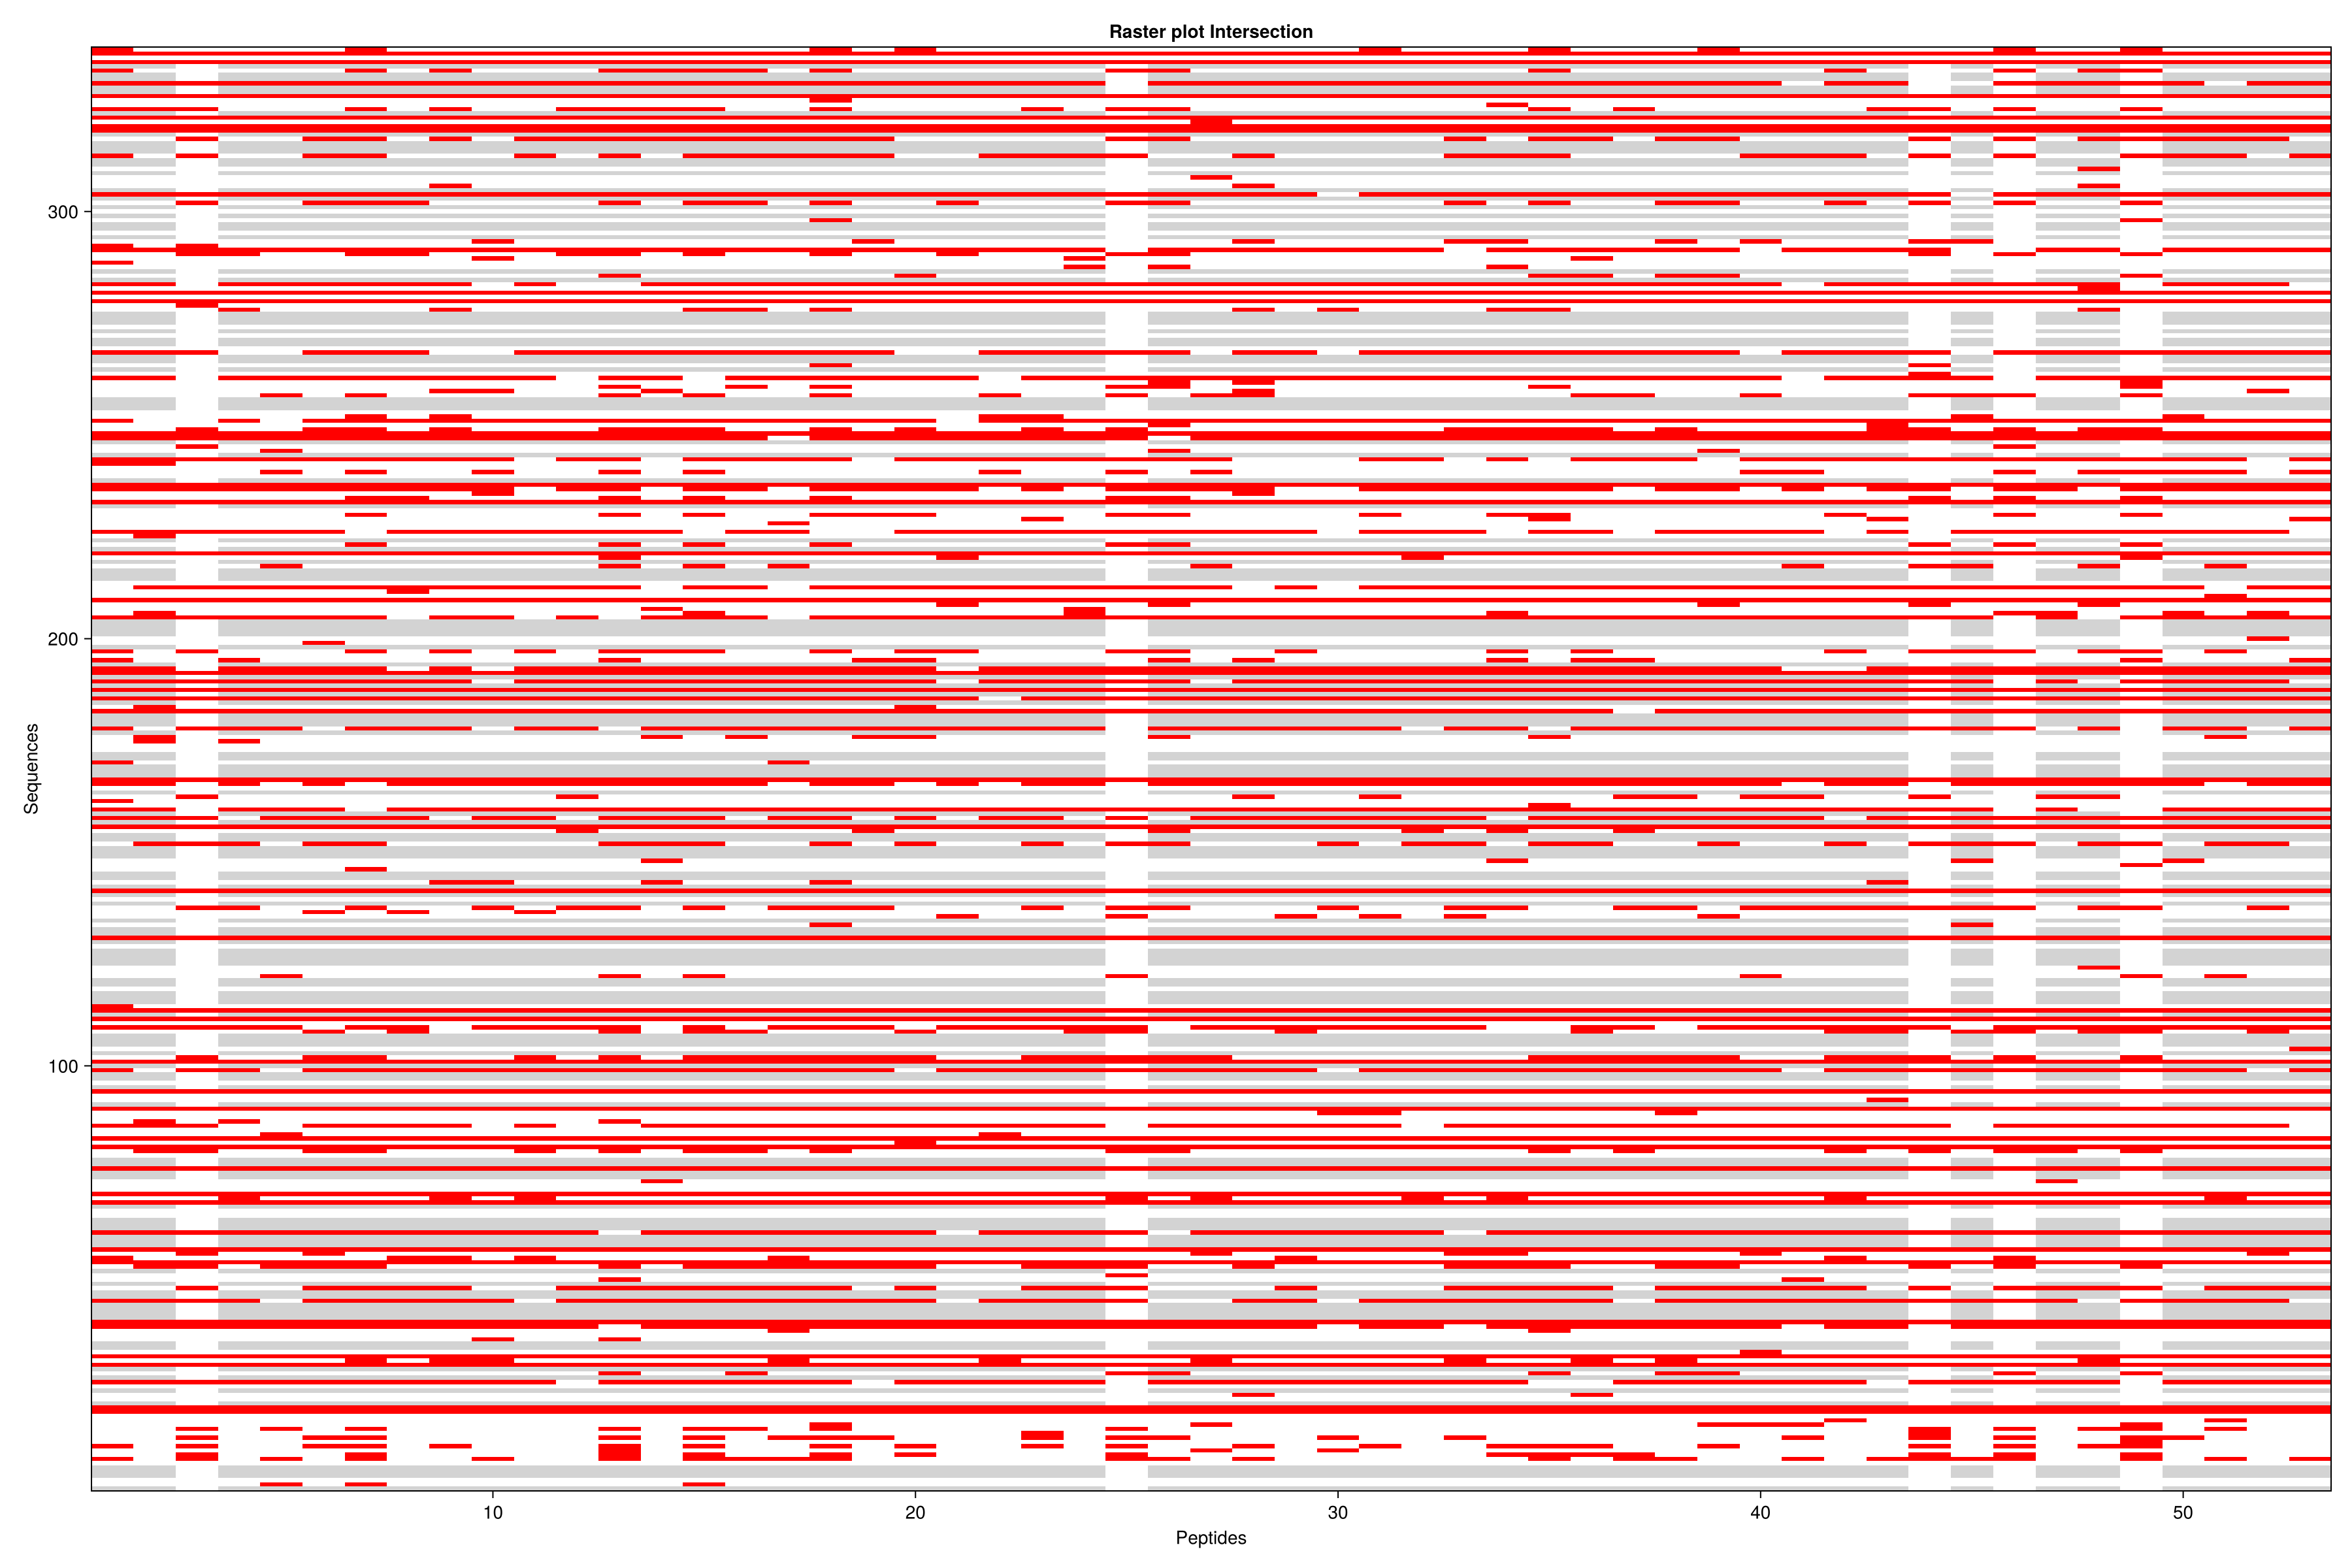

In [6]:
plot_label_matrix(union_dict, "Raster plot Intersection")

In [ ]:
function svd_overlap_plots(A::AbstractMatrix,
                           B::AbstractMatrix,
                           C::AbstractMatrix;
                           k::Int = 5,
                           abs_overlap::Bool = true,
                           colormap = :viridis)

    # --- sanity checks ---
    n = size(A, 1)
    @assert size(B, 1) == n && size(C, 1) == n """
    All matrices must have the same number of rows
    (same left singular vector space).
    """

    # --- SVDs ---
    UA = svd(A).U[:, 1:k]
    UB = svd(B).U[:, 1:k]
    UC = svd(C).U[:, 1:k]

    # --- overlaps ---
    overlap(X, Y) = abs_overlap ? abs.(X' * Y) : X' * Y

    OAB = overlap(UA, UB)
    OAC = overlap(UA, UC)
    OBC = overlap(UB, UC)

    labels = 1:k

    # --- helper for a single heatmap ---
    function overlap_heatmap(mat, title)
        fig = Figure(resolution = (500, 450))
        ax = Axis(fig[1, 1];
            title = title,
            xlabel = "Vector index",
            ylabel = "Vector index",
            xticks = (labels, string.(labels)),
            yticks = (labels, string.(labels)),
            aspect = DataAspect()
        )

        hm = heatmap!(ax, mat; colormap = colormap)
        Colorbar(fig[1, 2], hm, label = abs_overlap ? "|dot|" : "dot")

        return fig
    end

    figAB = overlap_heatmap(OAB, "Overlap: A vs B")
    figAC = overlap_heatmap(OAC, "Overlap: A vs C")
    figBC = overlap_heatmap(OBC, "Overlap: B vs C")

    return figAB, figAC, figBC
end


svd_overlap_plots (generic function with 1 method)

In [7]:
figAB, figAC, figBC = svd_overlap_plots(cov_matrix_Stiffler, cov_matrix_Gogl, cov_matrix_tot; k=5)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` o

(Scene(2 children, 0 plots), Scene(2 children, 0 plots), Scene(2 children, 0 plots))

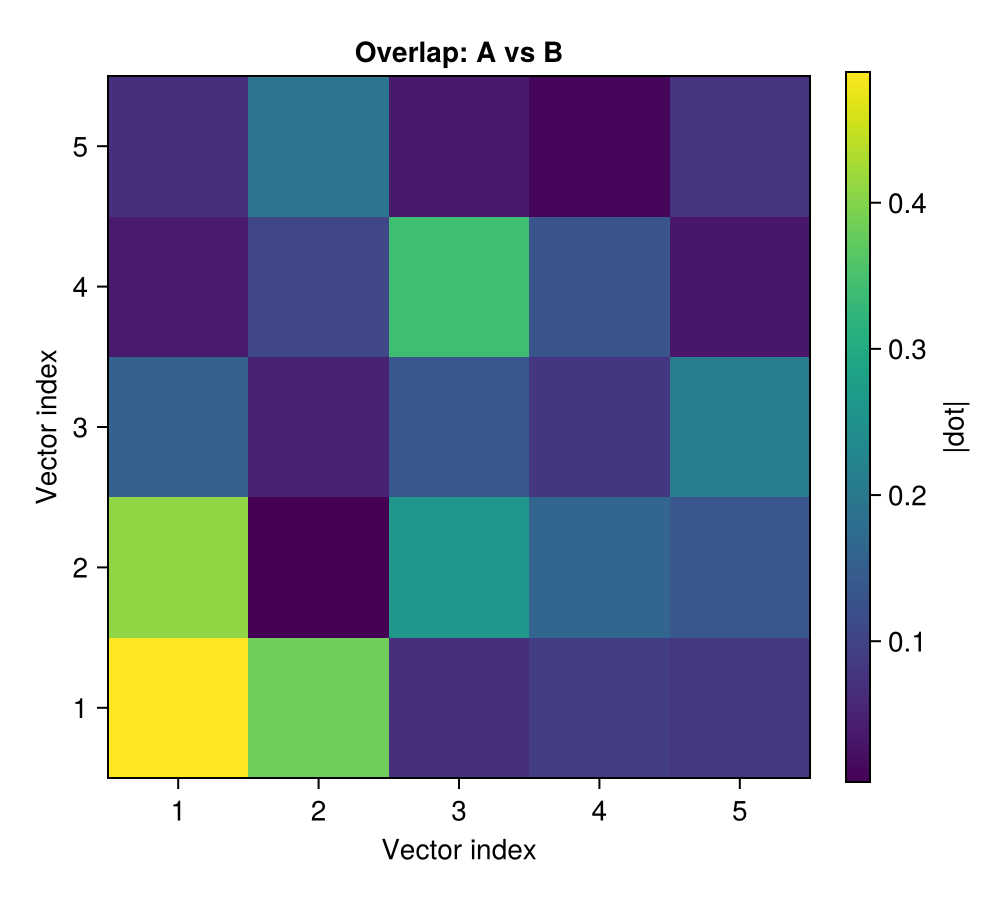

In [8]:
figAB

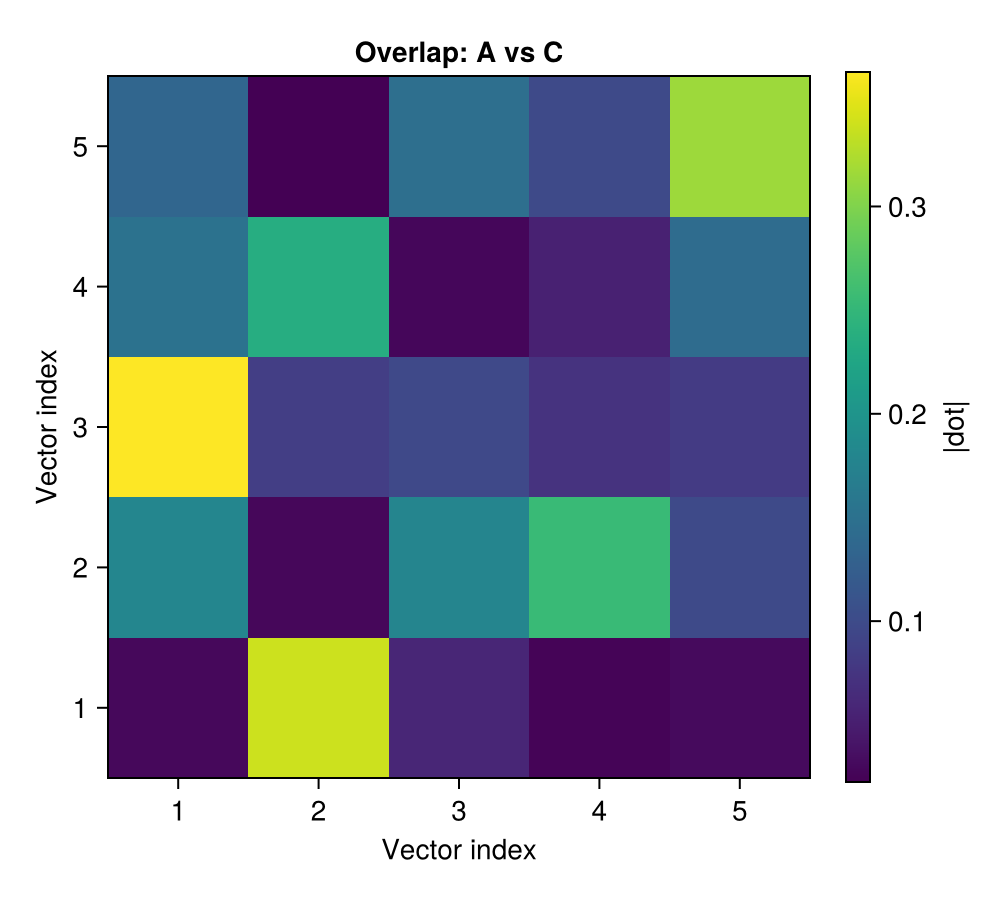

In [9]:
figAC

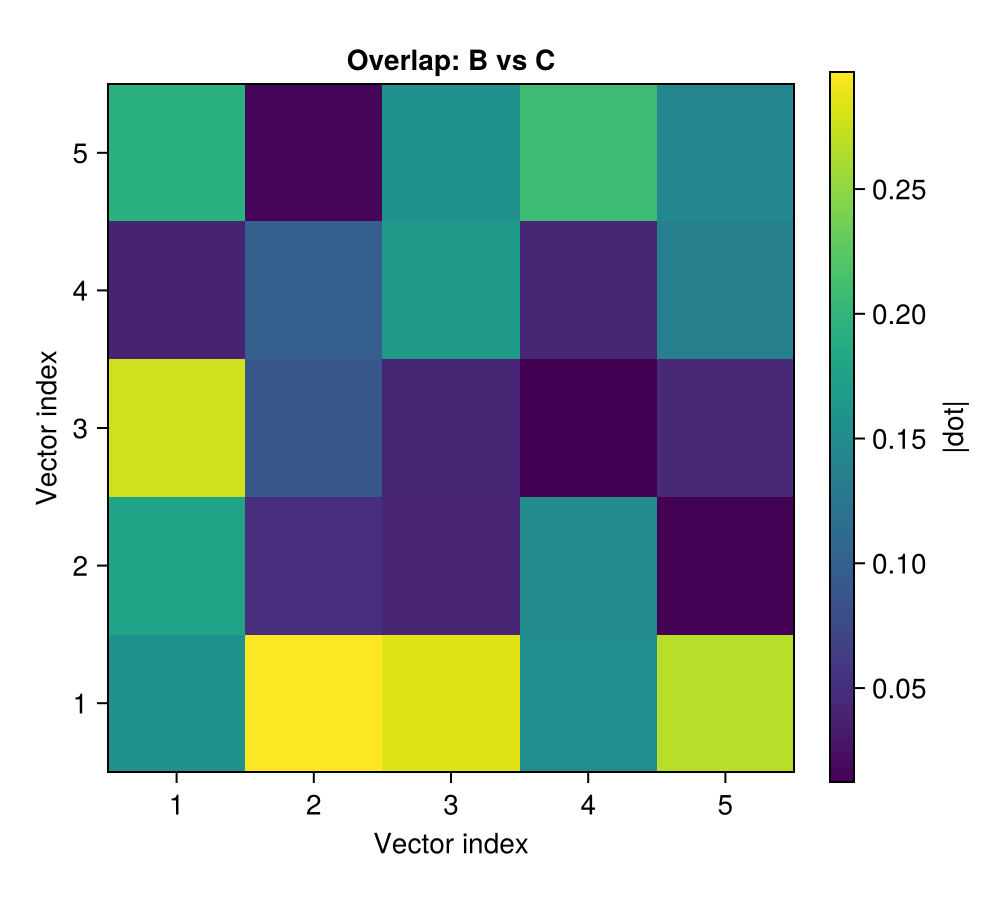

In [10]:
figBC

In [13]:
function pad_and_cluster(data::Dict{String, <:NamedTuple})

    keys_list = collect(keys(data))
    n_keys = length(keys_list)

    # --- 1. Global element universe ---
    all_elements = unique(vcat([data[k].elements for k in keys_list]...))
    element_index = Dict(e => i for (i, e) in enumerate(all_elements))
    n_elements = length(all_elements)

    # --- 2. Initialize label matrix with NaNs ---
    label_matrix = fill(NaN, n_keys, n_elements)

    total_possible = n_keys * n_elements
    observed = 0

    # --- 3. Fill observed labels (NO length assumption) ---
    for (i, k) in enumerate(keys_list)
        elems = data[k].elements
        labs  = data[k].labels

        for (e, l) in zip(elems, labs)
            j = element_index[e]
            label_matrix[i, j] = float(l)
            observed += 1
        end
    end

    # --- 4. Padding statistics ---
    padded = total_possible - observed
    padding_percentage = 100 * padded / total_possible

    # --- 5. Column-wise mean ignoring NaNs ---
    col_means = Vector{Float64}(undef, n_elements)

    for j in 1:n_elements
        col = label_matrix[:, j]
        valid = col[.!isnan.(col)]

        if isempty(valid)
            error("Element column $j has no observed labels — cannot impute.")
        end

        col_means[j] = mean(valid)
    end

    # --- 6. Impute missing entries ---
    for j in 1:n_elements
        for i in 1:n_keys
            if isnan(label_matrix[i, j])
                label_matrix[i, j] = col_means[j]
            end
        end
    end

    return label_matrix, padding_percentage
end


function remove_constant_columns(X::Matrix{Float64}; atol=1e-12)

    vars = vec(var(X; dims=1))
    keep = vars .> atol

    constants = Dict{Int, Float64}()

    for j in eachindex(keep)
        if !keep[j]
            # All values are equal up to numerical tolerance
            constants[j] = X[1, j]
        end
    end

    return X[:, keep], keep, constants
end

function scree_plot(label_matrix; kmax=15)

    X_filtered, keep, constants = remove_constant_columns(label_matrix)

    n_removed = length(constants)
    println("Removed $n_removed constant columns")

    if n_removed > 0
        println("Constant column values (column_index => value):")
        for (j, v) in constants
            println("  column $j => $v")
        end
    end

    X = X_filtered'   # features × samples
    inertias = Float64[]

    for k in 1:kmax
        result = kmeans(
            X,
            k;
            init=:kmpp,
            maxiter=300,
            display=:none
        )
        push!(inertias, result.totalcost)
    end

    fig = Figure(resolution=(600, 400))
    ax = Axis(
        fig[1, 1],
        xlabel="Number of clusters (k)",
        ylabel="Within-cluster sum of squares",
        title="Scree Plot"
    )

    lines!(ax, 1:kmax, inertias)
    scatter!(ax, 1:kmax, inertias)

    return fig
end


scree_plot (generic function with 1 method)

Percentage of padded elements: 33.35%
Removed 0 constant columns


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


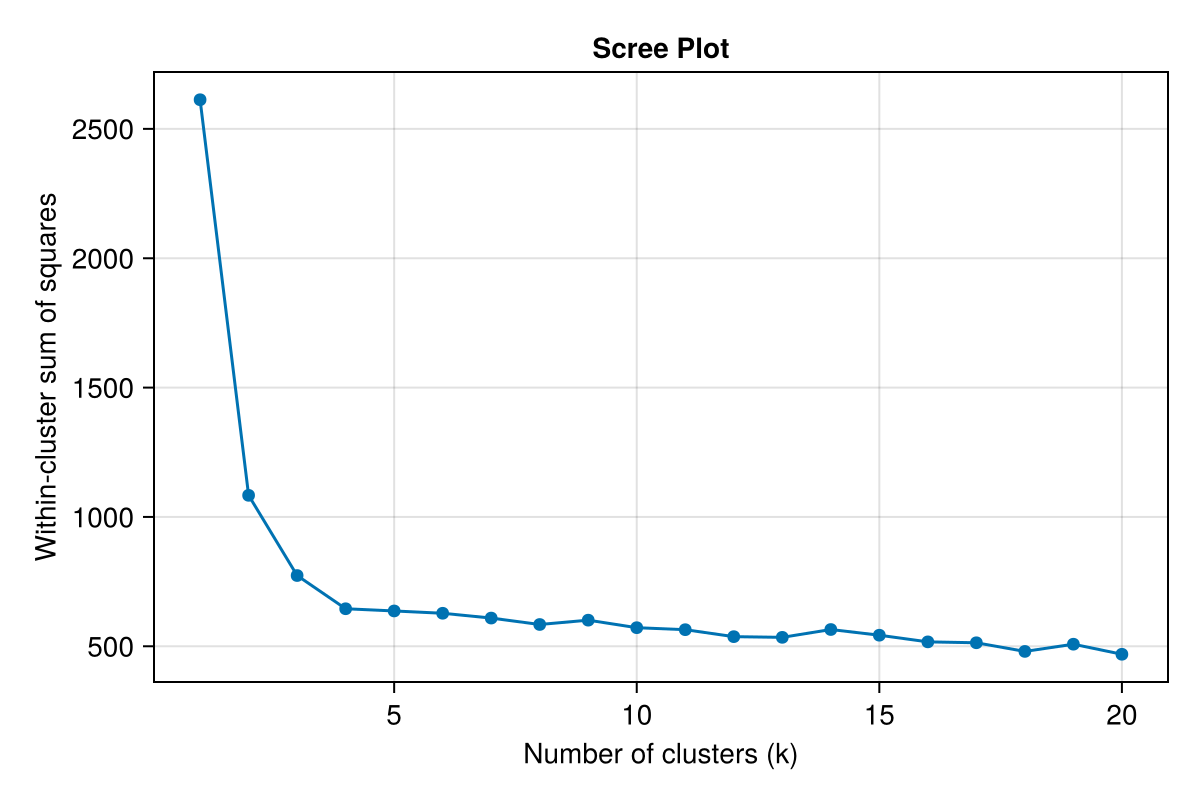

In [49]:
label_matrix, padding_pct = pad_and_cluster(union_dict)

println("Percentage of padded elements: $(round(padding_pct, digits=2))%")

fig = scree_plot(label_matrix; kmax=20)


Percentage of padded elements: 57.2%
Removed 14 constant columns
Constant column values (column_index => value):
  column 425 => 0.0
  column 519 => 0.0
  column 12 => 0.0
  column 374 => 0.0
  column 423 => 0.0
  column 11 => 0.0
  column 14 => 0.0
  column 214 => 0.0
  column 80 => 0.0
  column 337 => 0.0
  column 585 => 0.0
  column 417 => 0.0
  column 379 => 0.0
  column 376 => 0.0


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


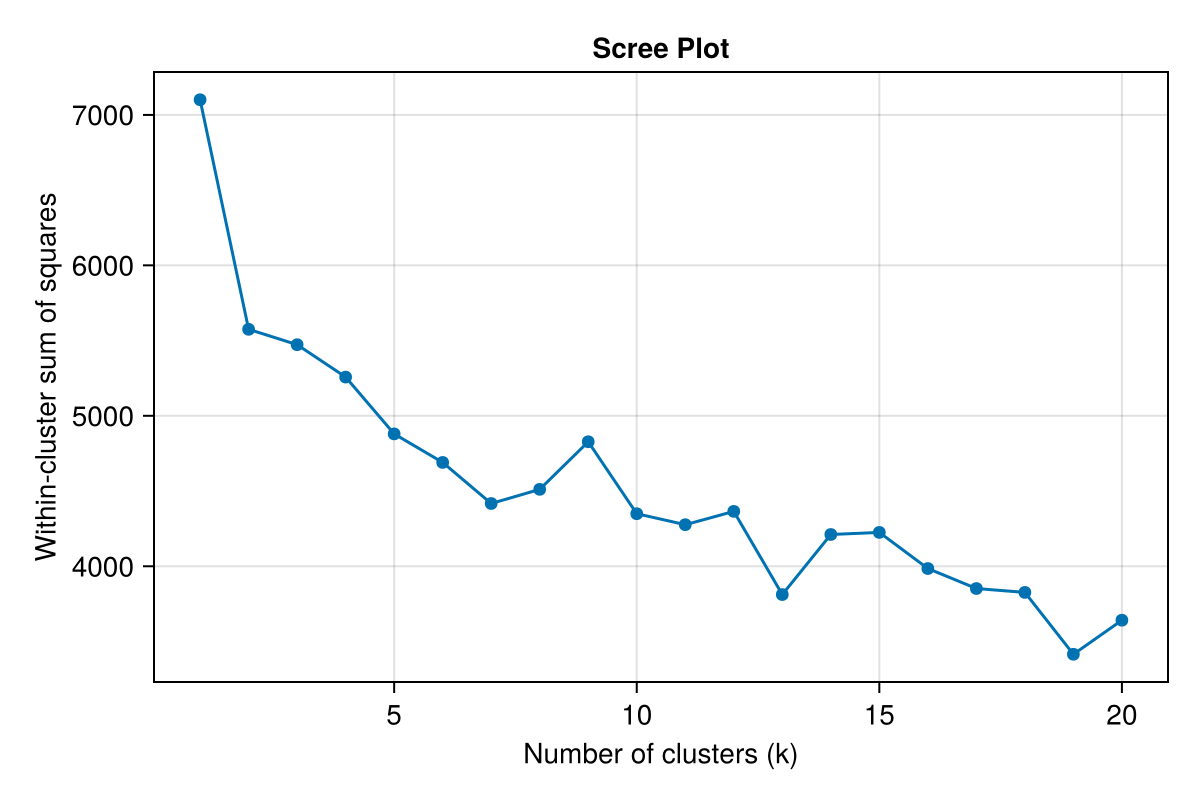

In [22]:
label_matrix, padding_pct = pad_and_cluster(union_tot)

println("Percentage of padded elements: $(round(padding_pct, digits=2))%")

fig = scree_plot(label_matrix; kmax=20)


In [15]:
label_matrix, padding_pct = pad_and_cluster(data_Gogl)
println("Percentage of padded elements: $(round(padding_pct, digits=2))%")


Percentage of padded elements: 38.48%


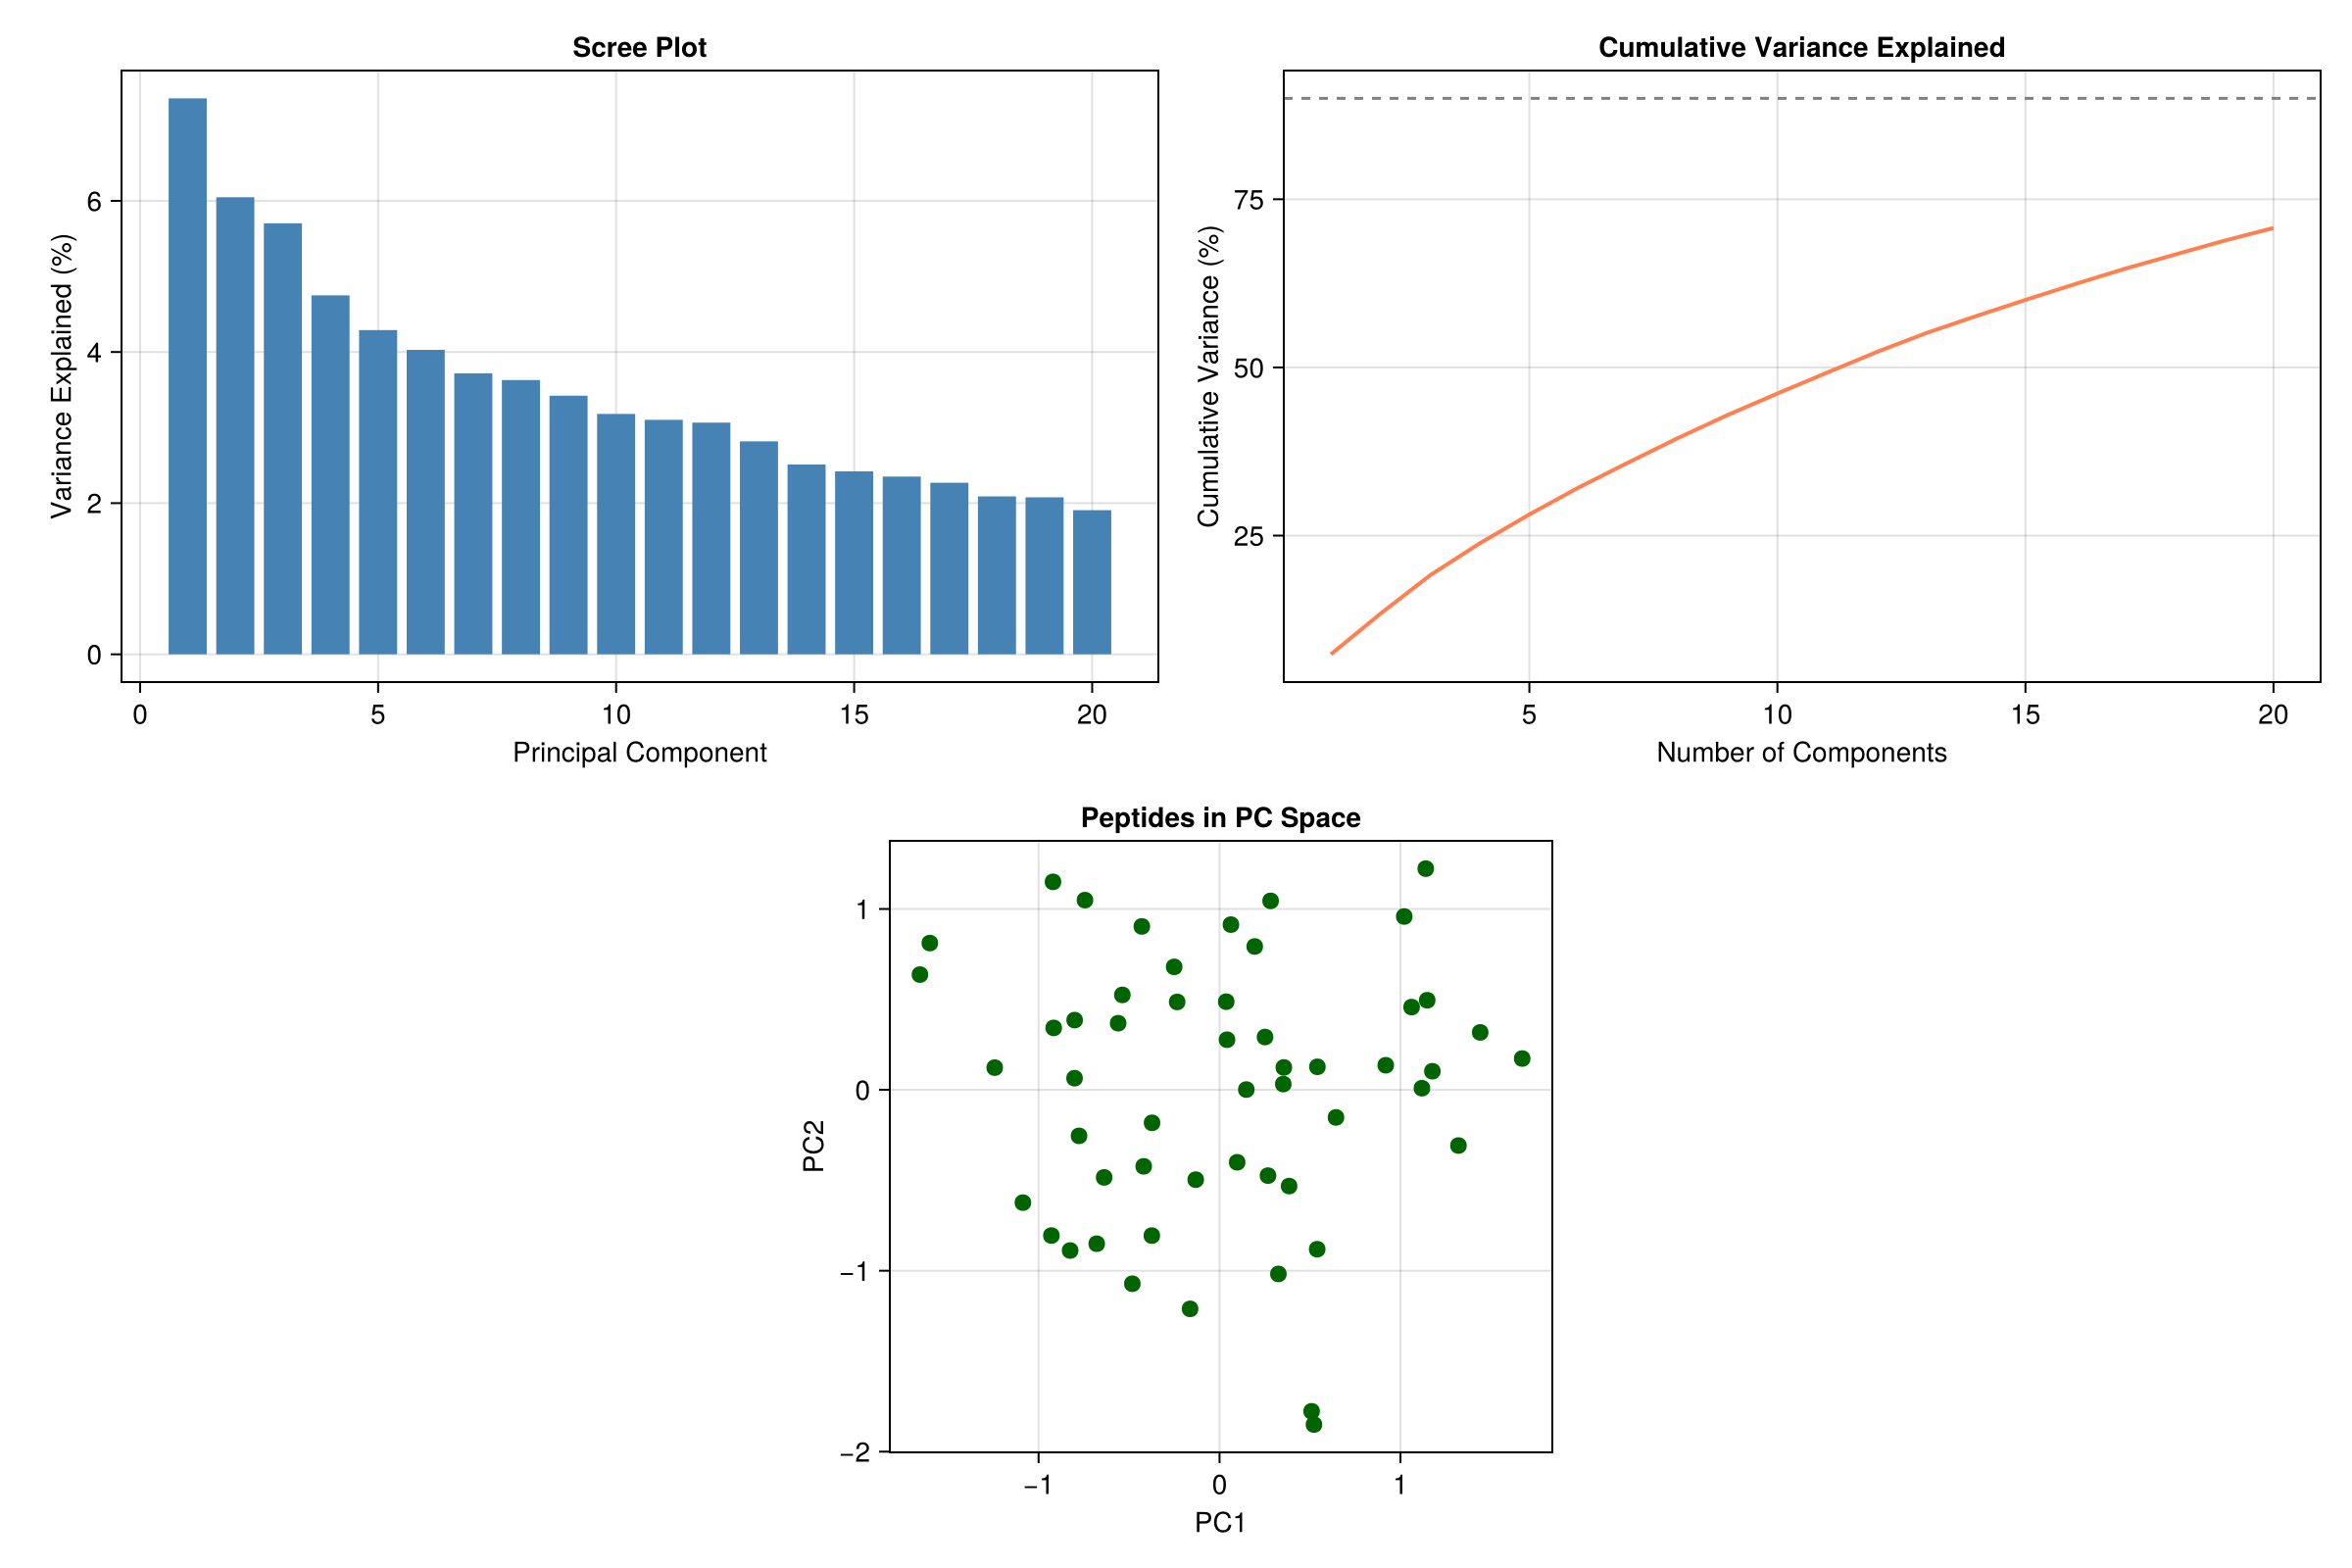

In [21]:
using LinearAlgebra, Statistics, CairoMakie

keys_list = collect(keys(union_dict))
n_keys = length(keys_list)

# --- 1. Global element universe ---
all_elements = unique(vcat([union_dict[k].elements for k in keys_list]...))
n_elements = length(all_elements)

peptides = onehot_encode_2d(all_elements, alphabet, alphabet_dict)
X_centered = peptides .- mean(peptides, dims=2)

# Compute covariance and eigendecomposition
C = (X_centered * X_centered') / (size(peptides,  2) - 1)
F = eigen(Symmetric(C))

# Sort by eigenvalues (descending)
idx = sortperm(F.values, rev=true)
eigenvalues = F.values[idx]
eigenvectors = F.vectors[:, idx]

# Explained variance
explained_var = eigenvalues ./ sum(eigenvalues)
cumsum_var = cumsum(explained_var)

# Transform to PC space
n_components = 20
components = eigenvectors[:, 1:n_components]'
X_transformed = components * X_centered
# Plot
fig = Figure(size=(1200, 800))

# Scree plot
ax1 = Axis(fig[1, 1], xlabel="Principal Component", ylabel="Variance Explained (%)",
           title="Scree Plot")
barplot!(ax1, 1:n_components, explained_var[1:n_components] .* 100, color=:steelblue)

# Cumulative variance
ax2 = Axis(fig[1, 2], xlabel="Number of Components", ylabel="Cumulative Variance (%)",
           title="Cumulative Variance Explained")
lines!(ax2, 1:n_components, cumsum_var[1:n_components] .* 100, color=:coral, linewidth=2)
hlines!(ax2, [90], color=:gray, linestyle=:dash, label="90%")

# PC1 vs PC2
ax3 = Axis(fig[2, 1:2], xlabel="PC1", ylabel="PC2", title="Peptides in PC Space",
           aspect=DataAspect())
scatter!(ax3, X_transformed[1, :], X_transformed[2, :], color=:darkgreen, markersize=12)

fig

In [ ]:
"""
    compute_pwms(data::Dict, alphabet::Vector{Char}, aa_to_index::Dict{Char, Int}; 
                 pseudocount::Float64=0.01)

Compute a Position Weight Matrix (PWM) for each protein sequence.

# Arguments
- `data::Dict`: Dictionary where keys are protein sequences, and values contain:
    - `.elements`: Vector of peptide sequences (strings)
    - `.labels`: Vector of binary labels (0/1) indicating binding
- `alphabet::Vector{Char}`: Vector of characters in the alphabet (e.g., amino acids)
- `aa_to_index::Dict{Char, Int}`: Mapping from characters to indices
- `pseudocount::Float64`: Pseudocount to avoid log(0) (default: 0.01)

# Returns
- `pwms::Dict`: Dictionary mapping each protein sequence to its PWM matrix of size (A, L) 
  where A is alphabet size and L is peptide length.
"""
function compute_pwms(data::Dict, alphabet::Vector{Char}, aa_to_index::Dict{Char, Int}; 
                      pseudocount::Float64=0.01)
    pwms = Dict()
    
    A = length(alphabet)  # alphabet size
    
    for (protein_key, protein_data) in data
        elements = protein_data.elements
        labels = protein_data.labels
        
        # Filter for binding peptides (label == 1)
        binding_peptides = String[]
        for (peptide, label) in zip(elements, labels)
            if label == 1
                push!(binding_peptides, peptide)
            end
        end
        
        # Skip if no binding peptides for this protein
        if isempty(binding_peptides)
            @warn "No binding peptides found for protein: $protein_key"
            continue
        end
        
        # Get peptide length
        L = length(binding_peptides[1])
        
        # Verify all peptides have the same length
        @assert all(length(seq) == L for seq in binding_peptides) "All peptides must have the same length for protein: $protein_key"
        
        # Compute PWM for this protein
        pwm = _compute_pwm_from_sequences(binding_peptides, alphabet, aa_to_index, L, A, pseudocount)
        
        # Store in dictionary
        pwms[protein_key] = pwm
    end
    
    return pwms
end

"""
    _compute_pwm_from_sequences(sequences::Vector{String}, alphabet::Vector{Char}, 
                                aa_to_index::Dict{Char, Int}, L::Int, A::Int, 
                                pseudocount::Float64)

Helper function to compute PWM from a collection of sequences.

Computes position-specific frequency matrix and converts to log-odds scores
assuming uniform background distribution.
"""
function _compute_pwm_from_sequences(sequences::Vector{String}, alphabet::Vector{Char}, 
                                    aa_to_index::Dict{Char, Int}, L::Int, A::Int, 
                                    pseudocount::Float64)
    N = length(sequences)  # number of binding sequences
    
    # Initialize count matrix: (A, L)
    counts = zeros(Float64, A, L)
    
    # Count amino acid occurrences at each position
    for seq in sequences
        for (pos, aa) in enumerate(seq)
            aa_idx = aa_to_index[aa]
            counts[aa_idx, pos] += 1.0
        end
    end
    
    # Add pseudocount to avoid zeros
    counts .+= pseudocount
    
    # Compute frequencies (normalize by column)
    frequencies = counts ./ (N + A * pseudocount)
    
    # Background frequency (uniform distribution)
    background_freq = 1.0 / A
    
    # Compute log-odds (PWM)
    # PWM[a, l] = log(P(a|l) / P(a))
    pwm = log.(frequencies ./ background_freq)
    
    return pwm
end

_compute_pwm_from_sequences

In [ ]:
pwms = compute_pwms(union_dict, alphabet, alphabet_dict)

┌ Warning: No binding peptides found for protein: -------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ
└ @ Main In[5]:39
┌ Warning: No binding peptides found for protein: -VTLEK-MSAGLGFSLEGGKGSLDKPLTINRIFKGAASEQSEVQPGDEILQLGGTAMQGLTRFEAWNIIKALPDPVTIVI-
└ @ Main In[5]:39
┌ Warning: No binding peptides found for protein: -------------------------------------------SPGDVLLEVNGTPVSGLTNRDTLAVIRHFREPIRLK--
└ @ Main In[5]:39
┌ Warning: No binding peptides found for protein: -VELTK-NVQGLGITIAGYIGDKPSGIFVKSITKSSAVEHDGIQIGDQIIAVDGTNLQGFTNQQAVEVLRHTGQTVLLTL-
└ @ Main In[5]:39
┌ Warning: No binding peptides found for protein: -------DGGPLGIHVVPFSARGTLGLLVKRLEKGGKAEHENFRENDCIVRINDGDLRNRRFEQAQHMFRQA---------
└ @ Main In[5]:39
┌ Warning: No binding peptides found for protein: -----TVSGNGLGIRIVGGKEIPEIGAYIAKILPGGSAEQTGLMEGMQVLEWNGIPLTSKTYEEVQSIISQQSGEI-----
└ @ Main In[5]:39
┌ Warning: No binding peptides found for protein: -----------YGFFLRIEKDTD--GHLIRVIEEGSPAEKAGLLDGDRVL

Dict{Any, Any} with 172 entries:
  "----------GLGFSIAGGVGNQ… => [-2.72692 -2.72692 … -2.72692 -2.72692; -2.72692…
  "-------KNPGLGFSISGGISGQ… => [-0.132293 -0.132293 … -0.132293 -4.74741; -0.13…
  "-IELEK-GSKGLGFSILDYQDPI… => [-4.21459 -4.21459 … -4.21459 0.400527; 0.400527…
  "----------GLGFSIAGGVGNQ… => [-2.72692 -2.72692 … -2.72692 -2.72692; -2.72692…
  "-VTLKRDPHRGFGFVINEGEYSG… => [0.0 -4.61512 … -4.61512 0.0; 0.0 -4.61512 … -4.…
  "-VVLTADPVTGFGIQLQGSVFAT… => [-1.75127 -1.75127 … -1.75127 -1.75127; -1.75127…
  "--QIDLQGPGPWGFRLVGGKDFE… => [-4.46262 -4.46262 … -4.46262 0.152502; 0.152502…
  "----------GLGFSIAGGTDNP… => [-2.35364 -2.35364 … -2.35364 -2.35364; -2.35364…
  "-VELPK-TDEGLGFNVMGGKEQN… => [-4.14162 -4.14162 … -4.14162 -4.14162; 0.473499…
  "----------GFGFTIIGGDEP-… => [-3.38681 -3.38681 … -3.38681 -3.38681; -3.38681…
  "----------GLGFNIVGGEDG-… => [-2.35364 -2.35364 … -2.35364 -2.35364; -2.35364…
  "-VQLTKTSVCDFGFAVTAQVDER… => [-0.231589 -0.919774 … -0.919774 -0.231589; -

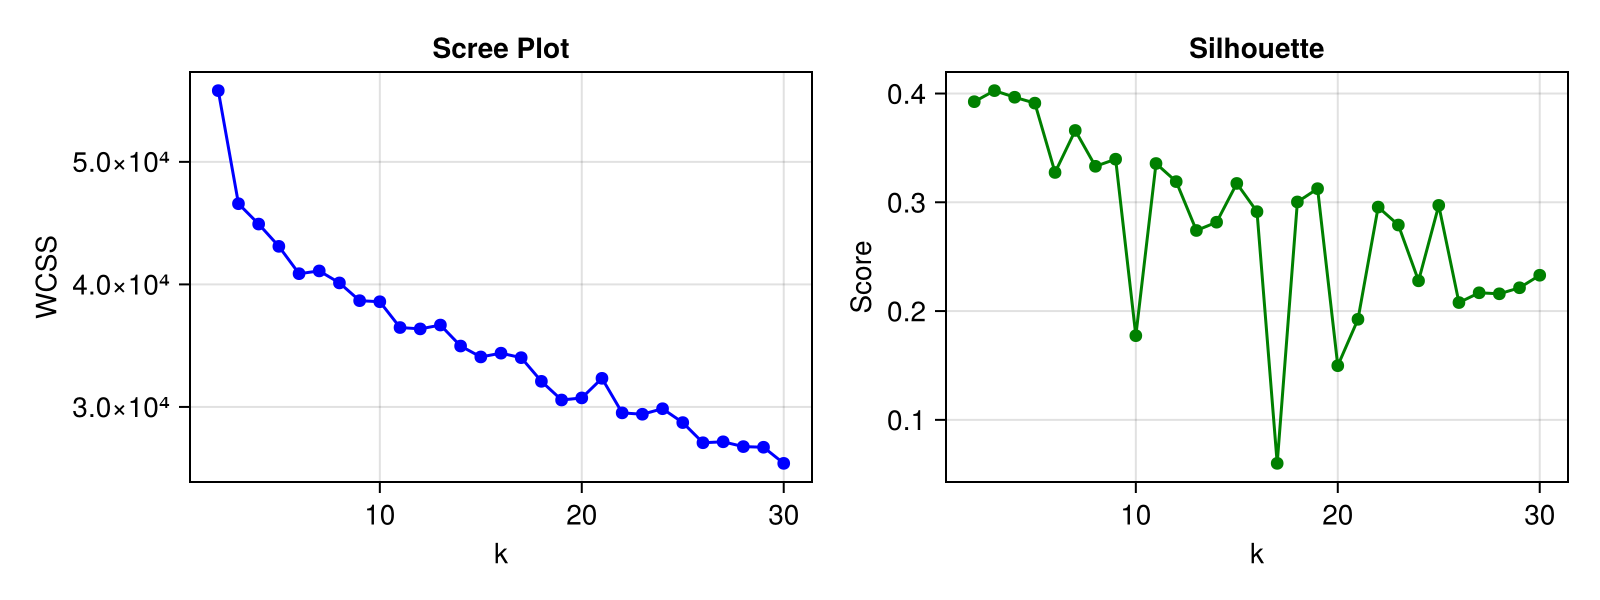

In [27]:
using Distances
protein_keys = collect(keys(pwms))
X = hcat([vec(pwms[k]) for k in protein_keys]...)

# Cluster and compute metrics
max_k = 30
wcss = Float64[]
sil_scores = Float64[]

for k in 2:max_k
    result = kmeans(X, k; maxiter=200)
    push!(wcss, result.totalcost)
    push!(sil_scores, mean(silhouettes(result, pairwise(Euclidean(), X))))
end

# Plot
k_range = 2:max_k
fig = Figure(size=(800, 300))

ax1 = Axis(fig[1, 1], xlabel="k", ylabel="WCSS", title="Scree Plot")
lines!(ax1, k_range, wcss, color=:blue)
scatter!(ax1, k_range, wcss, color=:blue)

ax2 = Axis(fig[1, 2], xlabel="k", ylabel="Score", title="Silhouette")
lines!(ax2, k_range, sil_scores, color=:green)
scatter!(ax2, k_range, sil_scores, color=:green)


fig
